In [1]:
# Checking if I'm in the right environment:
import sys
sys.executable

'C:\\Users\\mathe\\anaconda3\\envs\\deepchef\\python.exe'

In [2]:
# General libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
# This allows scrolling through all the columns. Useful for dataframes with too many columns.
pd.set_option('display.max_columns', None)

In [4]:
recipes = pd.read_parquet('BasicCleanData.parquet')

In [5]:
recipes.sample(2)

,RecipeId,AuthorId,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating
247883,257975.0,605192,Really tasty mac n cheese but with an extra ch...,Pasta,"[Cheese, Brunch, < 60 Mins]","[450, 8, 3⁄4, 1⁄2, 2, 1, 1⁄2, 1⁄2, 1, 2]","[pasta, evaporated milk, water, cheddar cheese...",NaN,674.2,31.8,18.4,126.1,1008.8,63.2,2.5,1.8,32.7,NaN,"[Boil pasta in a pot of water, add oil and/or ...",https://www.food.com/recipe/Baked-Mac-N-Cheese...,2007,10,9,0,40,NaN
229662,239255.0,299257,Make and share this Roasted Orange and Bell Pe...,Vegetables,"[Vegetable, < 4 Hours]","[1, 1, 2, 1⁄2, 1⁄3, 1 1⁄2, 1, 1⁄2, 1⁄8, 1⁄8, 1...","[navel orange, margarine, onion, carrot, all-p...",NaN,153.1,4.9,1.1,3.0,478.4,25.2,3.6,11.8,4.8,2.0,[Cut orange in half crosswise; slice about 1/4...,https://www.food.com/recipe/Roasted-Orange-and...,2007,7,9,13,80,NaN


In [6]:
recipes.isna().sum()/len(recipes)

RecipeId                      0.000000
AuthorId                      0.000000
Description                   0.000000
RecipeCategory                0.000000
Keywords                      0.000000
RecipeIngredientQuantities    0.000000
RecipeIngredientParts         0.000000
ReviewCount                   0.473648
Calories                      0.000000
FatContent                    0.000000
SaturatedFatContent           0.000000
CholesterolContent            0.000000
SodiumContent                 0.000000
CarbohydrateContent           0.000000
FiberContent                  0.000000
SugarContent                  0.000000
ProteinContent                0.000000
RecipeServings                0.350059
RecipeInstructions            0.000000
url                           0.000000
YearPublished                 0.000000
MonthPublished                0.000000
DayPublished                  0.000000
HourPublished                 0.000000
TotalMinutes                  0.000000
CorrectAggregatedRating  

In [17]:
recipes.loc[522515, 'url']

'https://www.food.com/recipe/Quick-&-Easy-Asian-Cucumber-Salmon-Rolls-541382'

In what follows, we will try to predict the missing values of recipe servings with KNN, PCA, Linear Regression and Decision Trees, and choose the one with higher performance.

## Data Preprocessing

First let's get rid of the irrelevant columns in the dataset.

In [7]:
recipes.corr(numeric_only=True)

,RecipeId,AuthorId,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating
RecipeId,1.000000,0.255584,-0.119986,-0.023462,-0.014314,-0.017051,-0.018058,-0.005428,-0.024017,0.000458,-0.023434,-0.008942,-0.000519,0.959403,0.004349,0.004863,-0.282798,0.002467,0.064282
AuthorId,0.255584,1.000000,-0.009010,0.005597,0.005948,0.005722,0.011599,0.005012,0.000200,0.008554,-0.002163,0.012042,-0.001247,0.372840,0.011449,0.006288,0.010520,0.011417,-0.004089
ReviewCount,-0.119986,-0.009010,1.000000,-0.003243,-0.003156,-0.001894,-0.000957,0.003121,-0.002562,-0.009041,-0.002172,0.001927,0.000033,-0.122350,-0.001410,0.000914,0.037679,0.011114,-0.003635
Calories,-0.023462,0.005597,-0.003243,1.000000,0.855637,0.832769,0.619356,0.172559,0.615499,0.401390,0.564226,0.655276,-0.008512,-0.021356,0.009755,-0.003879,0.007898,0.045552,-0.012563
FatContent,-0.014314,0.005948,-0.003156,0.855637,1.000000,0.971745,0.653320,0.144271,0.133113,0.177046,0.097771,0.620238,-0.011762,-0.012477,0.006270,-0.002769,0.004623,0.029951,-0.001388
SaturatedFatContent,-0.017051,0.005722,-0.001894,0.832769,0.971745,1.000000,0.669378,0.131565,0.129998,0.185495,0.097429,0.618262,-0.010721,-0.014987,0.007200,-0.002669,0.005423,0.029730,-0.002396
CholesterolContent,-0.018058,0.011599,-0.000957,0.619356,0.653320,0.669378,1.000000,0.119947,0.127829,0.086883,0.097968,0.707245,-0.006679,-0.014750,0.002832,-0.001448,0.006742,0.049749,-0.011583
SodiumContent,-0.005428,0.005012,0.003121,0.172559,0.144271,0.131565,0.119947,1.000000,0.099275,0.127017,0.071876,0.163970,-0.005363,-0.003326,0.001391,0.000400,0.002303,0.033195,-0.004348
CarbohydrateContent,-0.024017,0.000200,-0.002562,0.615499,0.133113,0.129998,0.127829,0.099275,1.000000,0.527203,0.960443,0.181900,-0.002962,-0.023121,0.011215,-0.003374,0.008447,0.023512,-0.021530
FiberContent,0.000458,0.008554,-0.009041,0.401390,0.177046,0.185495,0.086883,0.127017,0.527203,1.000000,0.385734,0.254252,-0.011899,0.000723,0.002079,-0.002704,-0.001302,0.044724,-0.002575


<Axes: >

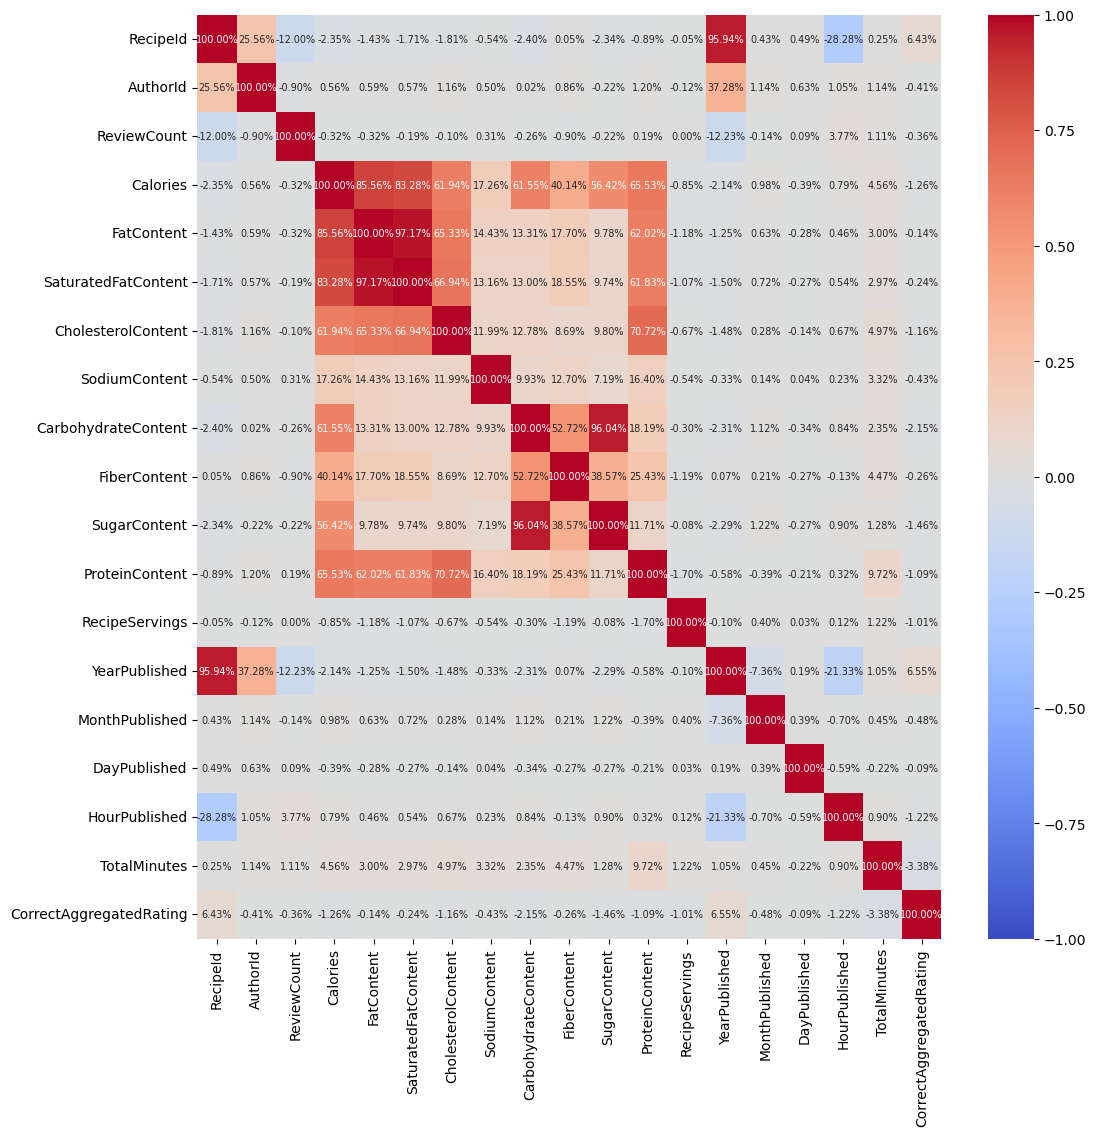

In [8]:
plt.figure(figsize=(12,12))
sns.heatmap(recipes.corr(numeric_only=True), cmap='coolwarm',annot=True,fmt=".2%",annot_kws={"fontsize": 7},vmax=1, vmin=-1, center=0)

Based on the correlation matrix, it seems that none of the variables have a strong correlation with the target variable "RecipeServings." Most of the correlations are close to zero, indicating weak linear relationships.

In such cases, it might be challenging to achieve a high accuracy using a linear regression model. However, you can still try different approaches to improve the model's performance. Here are a few suggestions:

**Feature engineering:** Consider creating new features by combining or transforming the existing variables. For example, you can calculate the ratio of certain nutrient contents, create interaction terms between variables, or derive new features based on domain knowledge. Feature engineering can help capture non-linear relationships and provide more predictive power to the model.

Non-linear models: Instead of using a linear regression model, you can explore non-linear models such as decision trees, random forests, or gradient boosting algorithms. These models can capture more complex relationships between the variables and the target. They may be more suitable for predicting "RecipeServings" if the relationship is non-linear.

Ensemble methods: Consider using ensemble methods, such as bagging or boosting, to combine multiple models for better performance. For example, you can create an ensemble of multiple decision tree models or combine decision trees with linear regression models to leverage their individual strengths.

Cross-validation: Utilize cross-validation techniques, such as k-fold cross-validation, to evaluate the model's performance on different subsets of the data. This can help assess the model's stability and identify potential issues of overfitting or underfitting.

Regularization: As mentioned earlier, you can apply regularization techniques such as L1 regularization (Lasso) or L2 regularization (Ridge) to prevent overfitting and improve the model's generalization ability. Regularization can also help in feature selection by shrinking the less relevant features towards zero.

It's important to note that the success of these approaches depends on the nature of your data and the underlying relationships between the variables. It's recommended to experiment with different techniques, evaluate their performance using appropriate metrics, and iterate on the feature engineering and modeling process to improve the accuracy of your predictions.

**Feature engineering:** It would seem that the number of servings has to do with ingredients and their ammounts. Let's try and make those available for modeling.

In [14]:
recipes['IngredientsCount'] = recipes['RecipeIngredientQuantities'].apply(lambda x: len(x))
recipes['IngredientsCount']

0          4
1         26
2          6
3         15
4          5
          ..
522512    12
522513     7
522514     6
522515     6
522516     9
Name: IngredientsCount, Length: 522512, dtype: int64

<Axes: >

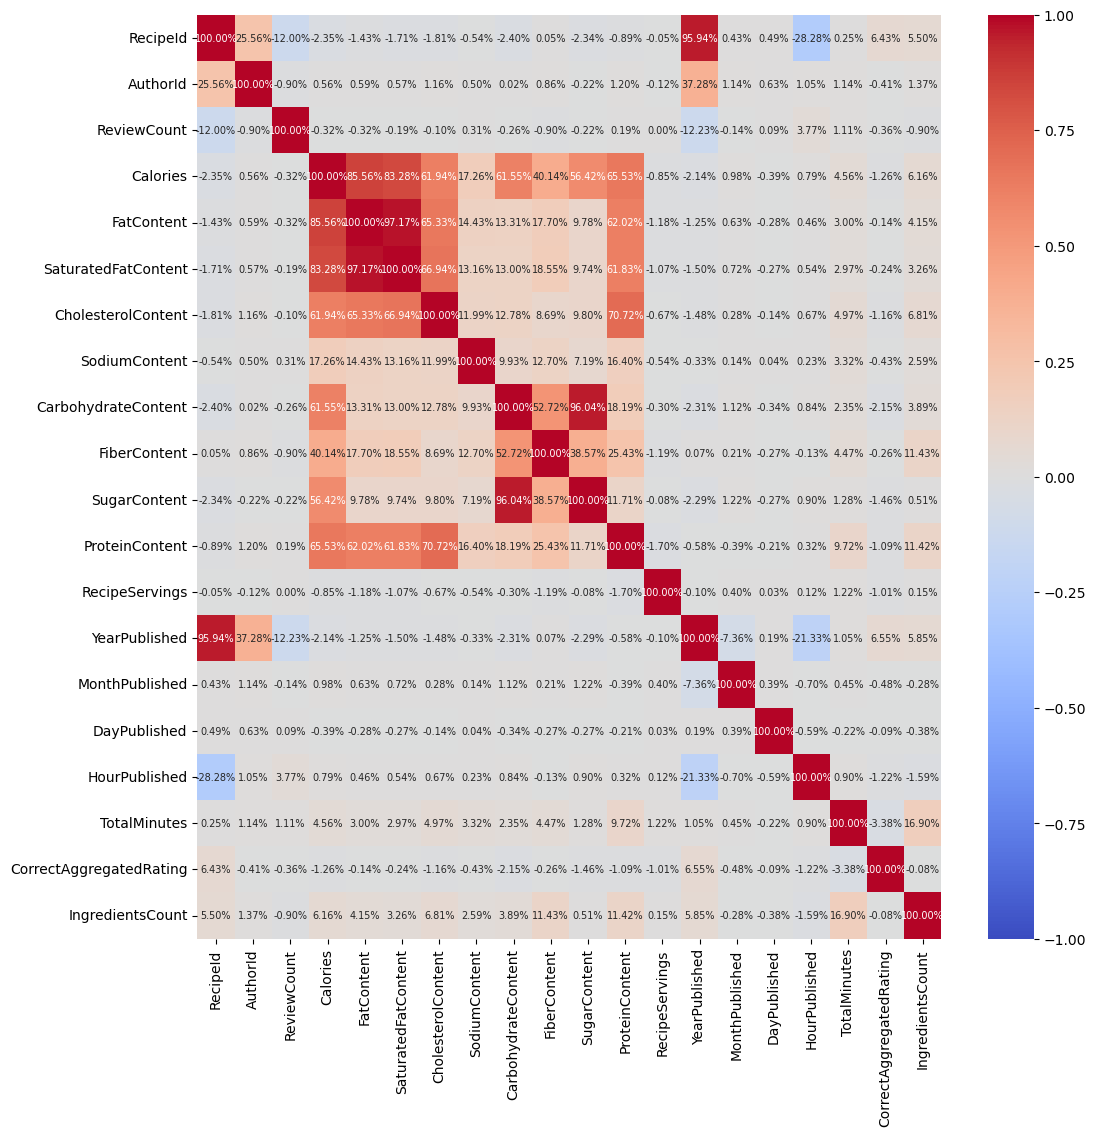

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(recipes.corr(numeric_only=True), cmap='coolwarm',annot=True,fmt=".2%",annot_kws={"fontsize": 7},vmax=1, vmin=-1, center=0)

In [21]:
recipes['RecipeServings'].value_counts() 

4.0       102893
6.0        61720
8.0        44894
12.0       26914
1.0        20819
           ...  
830.0          1
336.0          1
91.0           1
1210.0         1
228.0          1
Name: RecipeServings, Length: 171, dtype: int64

Lots of weird numbers!! Check out some of the extreme cases: they seem to be off

https://www.food.com/recipe/chocolate-silk-pie-283878

https://www.food.com/recipe/seafood-cornbread-351805


For now, I'll just focus on those recipes that have `RecipeServings` less than or equal to 20:

In [176]:
recipes20 = recipes[(recipes['RecipeServings'] <= 20) | recipes['RecipeServings'].isnull()]

In [177]:
recipes20.sample()

,RecipeId,AuthorId,Description,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,IngredientsCount
369252,382663.0,663997,Easy to make and a great way to use up leftove...,Poultry,"[Meat, European, High Protein, High In..., Wee...","[3, 1, 1⁄4, 1, 1⁄2, 2, 1⁄3, 1⁄3, 2]","[mayonnaise, egg, basil pesto, red onion, oliv...",1.0,469.0,22.6,4.6,129.4,963.2,32.3,5.3,4.8,34.6,4.0,"[Mix chicken, 1/2 cup bread crumbs, mayo, egg,...",https://www.food.com/recipe/Tuscan-Chicken-Cak...,2009,7,24,12,16,5.0,9


In [178]:
recipes20 = recipes20.reset_index(drop=True)

In [179]:
len(recipes20)

503071

In [180]:
recipes20.isna().sum()

RecipeId                           0
AuthorId                           0
Description                        0
RecipeCategory                     0
Keywords                           0
RecipeIngredientQuantities         0
RecipeIngredientParts              0
ReviewCount                   237707
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182910
RecipeInstructions                 0
url                                0
YearPublished                      0
MonthPublished                     0
DayPublished                       0
HourPublished                      0
TotalMinutes                       0
CorrectAggregatedRating       246389
IngredientsCount                   0
d

<Axes: >

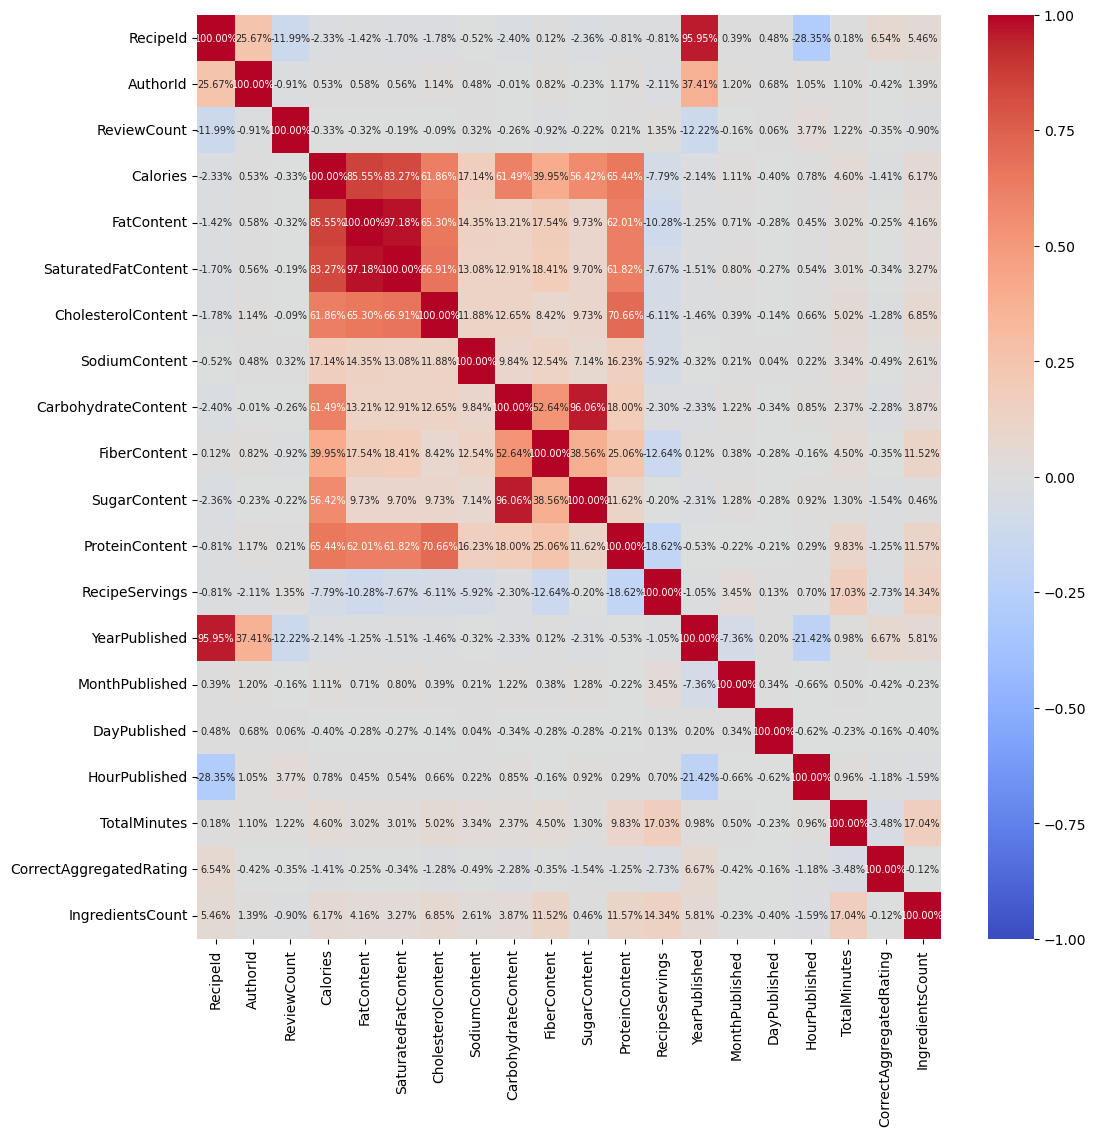

In [59]:
plt.figure(figsize=(12,12))
sns.heatmap(recipes20.corr(numeric_only=True), cmap='coolwarm',annot=True,fmt=".2%",annot_kws={"fontsize": 7},vmax=1, vmin=-1, center=0)

#### Ok now we see some good correlation!!

Now let's see if the correlations are statistically siginifcant. We'll run Pearson correlation test..

## Modeling 1
### Feature Selection

In [181]:
recipes20.columns

Index(['RecipeId', 'AuthorId', 'Description', 'RecipeCategory', 'Keywords',
       'RecipeIngredientQuantities', 'RecipeIngredientParts', 'ReviewCount',
       'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
       'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent',
       'ProteinContent', 'RecipeServings', 'RecipeInstructions', 'url',
       'YearPublished', 'MonthPublished', 'DayPublished', 'HourPublished',
       'TotalMinutes', 'CorrectAggregatedRating', 'IngredientsCount'],
      dtype='object')

In [182]:
recipes2 = recipes20[['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
       'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent',
       'ProteinContent', 'RecipeServings',
       'YearPublished', 'MonthPublished', 'DayPublished', 'HourPublished',
       'TotalMinutes', 'IngredientsCount']]

In [183]:
recipes2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503071 entries, 0 to 503070
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Calories             503071 non-null  float64
 1   FatContent           503071 non-null  float64
 2   SaturatedFatContent  503071 non-null  float64
 3   CholesterolContent   503071 non-null  float64
 4   SodiumContent        503071 non-null  float64
 5   CarbohydrateContent  503071 non-null  float64
 6   FiberContent         503071 non-null  float64
 7   SugarContent         503071 non-null  float64
 8   ProteinContent       503071 non-null  float64
 9   RecipeServings       320161 non-null  float64
 10  YearPublished        503071 non-null  int64  
 11  MonthPublished       503071 non-null  int64  
 12  DayPublished         503071 non-null  int64  
 13  HourPublished        503071 non-null  int64  
 14  TotalMinutes         503071 non-null  int64  
 15  IngredientsCount 

In [184]:
recipes2.isna().sum()

Calories                    0
FatContent                  0
SaturatedFatContent         0
CholesterolContent          0
SodiumContent               0
CarbohydrateContent         0
FiberContent                0
SugarContent                0
ProteinContent              0
RecipeServings         182910
YearPublished               0
MonthPublished              0
DayPublished                0
HourPublished               0
TotalMinutes                0
IngredientsCount            0
dtype: int64

In [185]:
recipes2.dropna(subset=['RecipeServings'],inplace=True)

C:\Users\mathe\AppData\Local\Temp\ipykernel_27784\2022141642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipes2.dropna(subset=['RecipeServings'],inplace=True)


In [186]:
recipes2.isna().sum()

Calories               0
FatContent             0
SaturatedFatContent    0
CholesterolContent     0
SodiumContent          0
CarbohydrateContent    0
FiberContent           0
SugarContent           0
ProteinContent         0
RecipeServings         0
YearPublished          0
MonthPublished         0
DayPublished           0
HourPublished          0
TotalMinutes           0
IngredientsCount       0
dtype: int64

Now let's specify our train and test data.

In [187]:
X = recipes2.drop(['RecipeServings'],axis=1)
y = recipes2[['RecipeServings']]

In [188]:
from sklearn.model_selection import train_test_split

# Train-Test-Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [189]:
X_train.shape

(288144, 15)

In [190]:
X_test.shape

(32017, 15)

### Scaling the Data

In [191]:
# Scaling the data

from sklearn.preprocessing import StandardScaler

# Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fit a Linear Regeression Model

In [97]:
from sklearn.linear_model import LinearRegression

# Let's use all the default parameters for now
lm = LinearRegression()

# Fitting to original data
lm.fit(X_train_scaled,y_train)

# Scoring on original train and test sets
print(f'Train Score: {lm.score(X_train_scaled, y_train)}')
print(f'Test Score: {lm.score(X_test_scaled, y_test)}')

Train Score: 0.12652189522854296
Test Score: 0.12983129946386063


### Use PCA to Transform the Data to its Principal Components -- then Linear Regression

In [192]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA to reduce dimensions to 10
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Fitting a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Assessing accuracy using R-squared score
accuracy = r2_score(y_test, y_pred)
print("Accuracy (R-squared):", accuracy)

Accuracy (R-squared): 0.12983129946386063


## Modeling 2:
### Bucketting `RecipeServings`
Let's further bucket our data into categories

In [193]:
recipes20['RecipeServings'].value_counts()

4.0     102893
6.0      61720
8.0      44894
12.0     26914
1.0      20819
2.0      19898
10.0     12987
16.0      8260
5.0       4515
20.0      4373
3.0       3602
15.0      2527
9.0       2303
18.0      2255
14.0      1044
7.0        831
11.0       137
13.0        99
17.0        53
19.0        37
Name: RecipeServings, dtype: int64

In [194]:
size_mapping = {
    1: 'small_size',
    2: 'small_size',
    3: 'small_size',
    4: 'small_size',
    5: 'small_size',
    6: 'medium_size',
    7: 'medium_size',
    8: 'medium_size',
    9: 'medium_size',
    10: 'medium_size',
    11: 'large_size',
    12: 'large_size',
    13: 'large_size',
    14: 'large_size',
    15: 'large_size',
    16: 'very_large_size',
    17: 'very_large_size',
    18: 'very_large_size',
    19: 'very_large_size',
    20: 'very_large_size'
}

In [195]:
recipes20['SizeCategory'] = recipes20['RecipeServings'].map(size_mapping)

In [196]:
recipes20['SizeCategory'].value_counts()

small_size         151727
medium_size        122735
large_size          30721
very_large_size     14978
Name: SizeCategory, dtype: int64

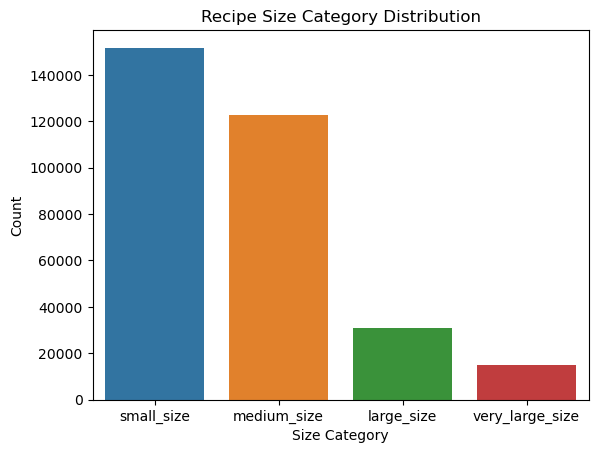

In [197]:
# Count the occurrences of each size category
size_counts = recipes20['SizeCategory'].value_counts()

# Create the bar plot
sns.barplot(x=size_counts.index, y=size_counts.values)

# Set labels and title
plt.xlabel('Size Category')
plt.ylabel('Count')
plt.title('Recipe Size Category Distribution')

# Display the plot
plt.show()


### Turning `SizeCategory` into One-Hot Encoding

In [198]:
from sklearn.preprocessing import OneHotEncoder

In [199]:
encoded = ohe.fit_transform(size_category)
encoded

<503071x5 sparse matrix of type '<class 'numpy.float64'>'
	with 503071 stored elements in Compressed Sparse Row format>

In [200]:
dense_array = encoded.toarray()
dense_array


array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [201]:
ohe.categories_

[array(['large_size', 'medium_size', 'small_size', 'very_large_size', nan],
       dtype=object)]

In [202]:
encoded_recipe_cat = pd.DataFrame(dense_array, columns=ohe.categories_, dtype='int')
encoded_recipe_cat

,large_size,medium_size,small_size,very_large_size,NaN
0,0,0,1,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
503066,0,1,0,0,0
503067,0,1,0,0,0
503068,0,1,0,0,0
503069,0,0,0,0,1


In [ ]:
recipes20 = pd.concat([recipes20,encoded_recipe_cat],axis=1)

###  PCA PLAYGROUND


In [75]:
# Instantiate & fit PCA model to the data

from sklearn.decomposition import PCA
my_PCA = PCA()
my_PCA.fit(X_train_scaled)

# transform data 
X_train_PCA = my_PCA.transform(X_train_scaled)
X_test_PCA = my_PCA.transform(X_test_scaled)

In [76]:
X_train_PCA.shape

(288144, 15)

In [77]:
X_train_scaled.shape

(288144, 15)

Principal components (PCs) are created to be orthogonal to each other, which means they are not correlated or collinear. When performing PCA, the components are derived in such a way that they capture the maximum amount of variance in the original dataset while being uncorrelated with each other.

The purpose of PCA is to reduce the dimensionality of the data while retaining the most important information. Each principal component is a linear combination of the original features, with the weights (loadings) assigned in a way that maximizes the explained variance. As a result, the principal components are independent and free from collinearity.

Collinearity refers to a high correlation between independent variables (features) in a regression model. It can lead to issues such as unstable coefficients and difficulties in interpreting the model. PCA can help address collinearity in the sense that it transforms the original features into orthogonal components, reducing the chance of multicollinearity in subsequent regression models.

However, it's important to note that while the principal components themselves are uncorrelated, the original features from which they are derived may still exhibit collinearity. Therefore, if you encounter collinearity issues in the original features, applying PCA may not completely eliminate them. In such cases, other techniques like feature selection or regularization methods can be used to mitigate collinearity before or after applying PCA.

<Axes: >

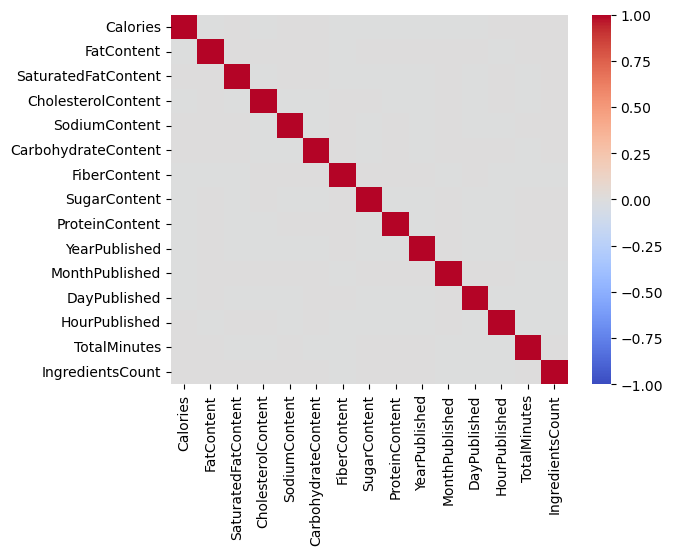

In [78]:
sns.heatmap(pd.DataFrame(X_train_PCA,columns=X_train.columns).corr(),cmap='coolwarm',vmin=-1,vmax=1)

<Axes: >

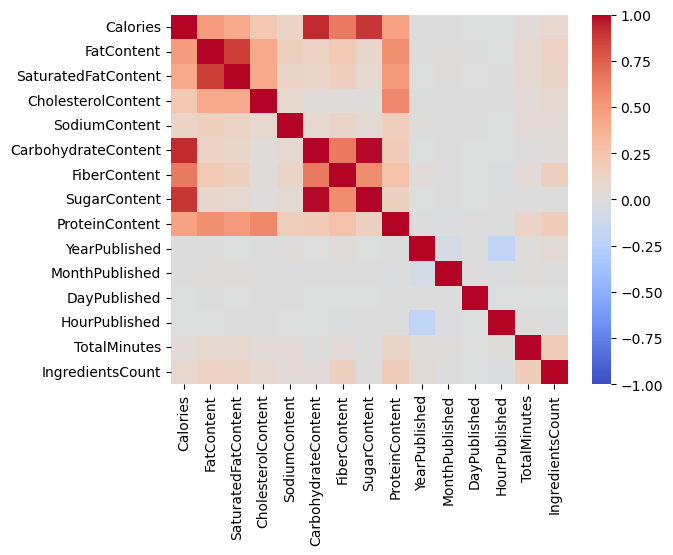

In [79]:
sns.heatmap(pd.DataFrame(X_train_scaled,columns=X_train.columns).corr(),cmap='coolwarm',vmin=-1,vmax=1)

In [80]:
print(f"Variance captured by PC1: {my_PCA.explained_variance_[0]: 0.3f}")
print(f"Variance captured by PC2: {my_PCA.explained_variance_[1]: 0.3f}")

print(f"Proportion of variance captured by PC1: {my_PCA.explained_variance_ratio_[0]: 0.3f}")
print(f"Proportion of variance captured by PC2: {my_PCA.explained_variance_ratio_[1]: 0.3f}")

Variance captured by PC1:  3.946
Variance captured by PC2:  2.311
Proportion of variance captured by PC1:  0.263
Proportion of variance captured by PC2:  0.154


In [82]:
my_PCA.explained_variance_ratio_

array([2.63067518e-01, 1.54054390e-01, 8.18231160e-02, 7.58196271e-02,
       6.73903459e-02, 6.63182546e-02, 6.41955742e-02, 5.55829548e-02,
       5.25336092e-02, 5.22875103e-02, 3.43141560e-02, 2.32636745e-02,
       8.55717085e-03, 7.45331069e-04, 4.67670023e-05])

In [83]:
expl_var = my_PCA.explained_variance_ratio_

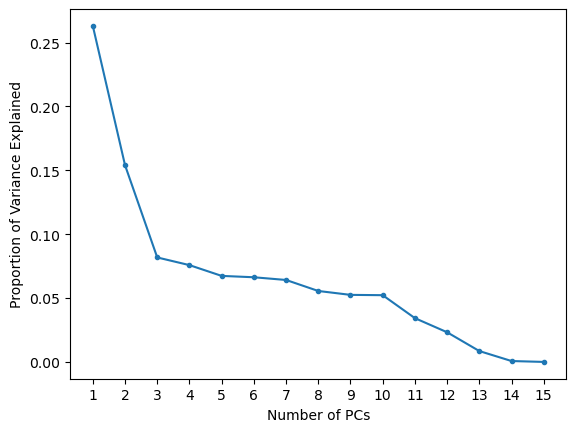

In [85]:
plt.figure()
plt.plot(range(1,16),expl_var,marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,16,1))
plt.show()

In [86]:
# Pull out the explained variance ratio
expl_var = my_PCA.explained_variance_ratio_

# Calculate the cumulative sum of this array using the 
cumulative_sum = np.cumsum(expl_var)

cumulative_sum

array([0.26306752, 0.41712191, 0.49894502, 0.57476465, 0.642155  ,
       0.70847325, 0.77266883, 0.82825178, 0.88078539, 0.9330729 ,
       0.96738706, 0.99065073, 0.9992079 , 0.99995323, 1.        ])

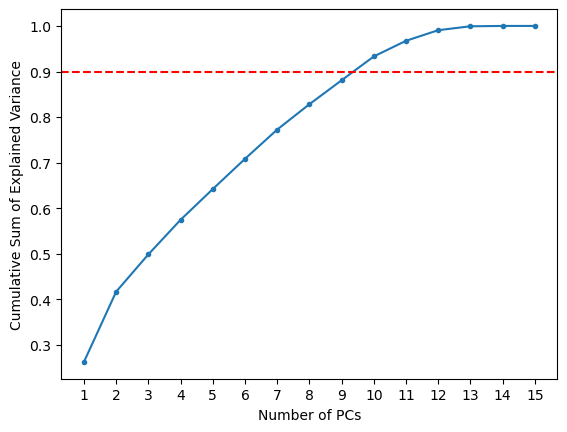

In [88]:
# Plot out the cumulative sum graph

plt.figure()
plt.plot(range(1,16), cumulative_sum, marker='.')
plt.axhline(0.9, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.xticks(range(1,16,1))
plt.show()

In [89]:
# Instantiate and fit
my_PCA = PCA(n_components = 10)
my_PCA.fit(X_train_scaled)

# Transform train and test
X_train_PCA = my_PCA.transform(X_train_scaled)
X_test_PCA = my_PCA.transform(X_test_scaled)

In [90]:
print(f'Original: {X_train_scaled.shape}')
print(f'PCA Transformed: {X_train_PCA.shape}')

Original: (288144, 15)
PCA Transformed: (288144, 10)


## Fit a Model to the Principal Components

In [50]:
# OLD RESULTS BEFORE DROPPING EXTREME CASES OF RECIPESERVINGS:

Train Score: 0.0006249562362197203
Test Score: 0.02469650844066751


In [91]:
from sklearn.linear_model import LinearRegression

# Let's use all the default parameters for now
lm = LinearRegression()

# Fitting to original data
lm.fit(X_train_scaled,y_train)

# Scoring on original train and test sets
print(f'Train Score: {lm.score(X_train_scaled, y_train)}')
print(f'Test Score: {lm.score(X_test_scaled, y_test)}')


Train Score: 0.12829566823624128
Test Score: 0.11779751083294099


In [51]:
# OLD RESULTS BEFORE DROPPING EXTREME CASES OF RECIPESERVINGS:

Train Score: 0.0006249562362197203
Test Score: 0.02469650844066762


In [92]:
from sklearn.linear_model import LinearRegression
lmPCA = LinearRegression()

# Fitting to PCA data
lmPCA.fit(X_train_PCA,y_train)

# Scoring on PCA train and test sets
print(f'Train Score: {lmPCA.score(X_train_PCA, y_train)}')
print(f'Test Score: {lmPCA.score(X_test_PCA, y_test)}')

Train Score: 0.06550929300534925
Test Score: 0.08209173149533666


In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA to reduce dimensions to 10
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Fitting a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Assessing accuracy using R-squared score
accuracy = r2_score(y_test, y_pred)
print("Accuracy (R-squared):", accuracy)


Accuracy (R-squared): 0.12983129946386063
